In [1]:
import re

import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM


/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def load_model_and_tokenizer(model_id, cache_dir="../../models", local_files_only=True):
    """Load model and tokenizer with error handling."""
    try:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            cache_dir=cache_dir,
            local_files_only=local_files_only
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=quantization_config,
            device_map="auto",
            cache_dir=cache_dir,
            local_files_only=local_files_only
        )
        model.eval()
        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def load_npy_file(file_path):
    """Load the npy file from the given path."""
    return np.load(file_path)

def get_symbol_index(data):
    """Generate a symbol index array based on data length."""
    return np.arange(data.shape[0])

def extract_signal_features(data):
    """
    Extract I and Q components along with magnitude and phase.
    
    Returns I, Q, magnitude, phase as float16 arrays.
    """
    I = data.real.astype(np.float16)
    Q = data.imag.astype(np.float16)
    magnitude = np.abs(data).astype(np.float16)
    phase = np.angle(data, deg=True).astype(np.float16)
    return I, Q, magnitude, phase

def create_structured_table(symbol_idx, I, Q, magnitude, phase):
    """
    Combine signal data into a structured numpy array table.
    
    Returns a structured array with fields:
      - 'Symbol Index'
      - 'I (Real)'
      - 'Q (Imaginary)'
      - 'Magnitude'
      - 'Phase (°)'
    """
    table = np.zeros(symbol_idx.shape[0], dtype=[
        ('Symbol Index', np.int32),
        ('I (Real)', np.float16),
        ('Q (Imaginary)', np.float16),
        ('Magnitude', np.float16),
        ('Phase (°)', np.float16)
    ])
    table['Symbol Index'] = symbol_idx
    table['I (Real)'] = I
    table['Q (Imaginary)'] = Q
    table['Magnitude'] = magnitude
    table['Phase (°)'] = phase
    return table

def create_dataframe(table):
    """Convert a structured numpy array into a pandas DataFrame."""
    return pd.DataFrame(table)

def compute_overall_summary(df_table):
    """
    Compute overall min, max, mean, and standard deviation for
    I (Real), Q (Imaginary), Magnitude, and Phase.
    """
    summary = (
        df_table[['I (Real)', 'Q (Imaginary)', 'Magnitude', 'Phase (°)']]
        .agg(['min', 'max', 'mean', 'std'])
        .T
        .reset_index()
    )
    summary.columns = ['Parameter', 'Min', 'Max', 'Mean', 'Std Dev']
    return summary

def compute_group_summary(df_table, k=100):
    """
    Compute group statistics (min, max, mean, std) for every k indices.
    
    Returns the summary in long format.
    """
    df_table['Group'] = df_table['Symbol Index'] // k
    group_sum = (
        df_table.groupby('Group')[['I (Real)', 'Q (Imaginary)', 'Magnitude', 'Phase (°)']]
        .agg(['min', 'max', 'mean', 'std'])
    )
    # Reshape: one row per group and parameter
    group_sum = group_sum.stack(level=0).reset_index()
    group_sum.rename(columns={'level_1': 'Parameter'}, inplace=True)
    group_sum = group_sum[['Group', 'Parameter', 'min', 'max', 'mean', 'std']]
    group_sum.columns = ['Group', 'Parameter', 'Min', 'Max', 'Mean', 'Std Dev']
    return group_sum

def table_to_dict_list(table):
    """
    Convert a structured numpy array table or a pandas DataFrame into a list of dictionaries,
    where each dictionary represents a row with keys as column names and values as cell data.
    """
    if hasattr(table, 'dtype') and table.dtype.names is not None:
        col_names = table.dtype.names
        return [{col: row[col] for col in col_names} for row in table]
    elif isinstance(table, pd.DataFrame):
        return table.to_dict(orient="records")
    else:
        raise ValueError("Unsupported table format")
    
def clean_response(response):
    """
    Clean the response string by removing unwanted characters.
    """
    response = re.sub(r'<[^>]*>', '', response)
    response = re.sub(r'\s+', '', response)
    return response.replace("'", "").replace('"', '')

def get_signal_summary(file_path, div=10):
    data = load_npy_file(file_path)

    label = file_path.split('/')[-1].split('_')[0]

    k = data.shape[0] // div
    # print(k<data.shape[0]*div+1)

    symbol_idx = get_symbol_index(data)
    I, Q, magnitude, phase = extract_signal_features(data)
    table = create_structured_table(symbol_idx, I, Q, magnitude, phase)
    df_table = create_dataframe(table)

    overall = compute_overall_summary(df_table)
    group = compute_group_summary(df_table, k=k)

    return overall, group, data.shape, k, label

def get_stats_context(file_path, decimal_precision=3):
    data = load_npy_file(file_path)
    label = file_path.split('/')[-1].split('_')[0]
    des_stats = stats.describe(data)
    stats_summary = {
        'nobs': f'{des_stats.nobs}',
        'min': f"{des_stats.minmax[0]:.{decimal_precision}f}",
        'max': f"{des_stats.minmax[1]:.{decimal_precision}f}",
        'mean': f"{des_stats.mean:.{decimal_precision}f}",
        'variance': f"{des_stats.variance:.{decimal_precision}f}",
        'skewness': f"{des_stats.skewness:.{decimal_precision}f}",
        'kurtosis': f"{des_stats.kurtosis:.{decimal_precision}f}",
    }
    for i in range(10):
        stats_summary[f'moment_{i}'] = f'{stats.moment(data, order=i):.{decimal_precision}f}'

    for i in range(1, 5):
        stats_summary[f'kstat_{i}'] = f'{stats.kstat(data, i):.{decimal_precision}f}'

    for i in range(1, 3):
        stats_summary[f'kstatvar_{i}'] = f'{stats.kstatvar(data, i):.{decimal_precision}f}'


    return str(stats_summary).replace("'", ''), label

def get_example_paths(noise_type='noisySignal'):
    example_paths = {
        '4ASK': f'../data/unlabeled_10k/test/{noise_type}/4ASK_-0.17dB__081_20250127_164342.npy',
        '8ASK': f'../data/unlabeled_10k/test/{noise_type}/8ASK_-0.11dB__016_20250127_164352.npy',
        '16PAM': f'../data/unlabeled_10k/test/{noise_type}/16PAM_-0.08dB__058_20250127_145951.npy',
        'CPFSK': f'../data/unlabeled_10k/test/{noise_type}/CPFSK_-0.03dB__088_20250127_164523.npy',
        'DQPSK': f'../data/unlabeled_10k/test/{noise_type}/DQPSK_-0.01dB__036_20250127_164655.npy',
        'GFSK': f'../data/unlabeled_10k/test/{noise_type}/GFSK_-0.05dB__042_20250127_164545.npy', 
        'GMSK': f'../data/unlabeled_10k/test/{noise_type}/GMSK_-0.12dB__059_20250127_164925.npy',
        'OQPSK': f'../data/unlabeled_10k/test/{noise_type}/OQPSK_-0.24dB__006_20250127_145655.npy',
        'OOK': f'../data/unlabeled_10k/test/{noise_type}/OOK_-0.17dB__091_20250127_164311.npy'
    }

    return example_paths

def create_stats_prompt(file_path, noise_type='noisySignal'):
    stats_summary, label = get_stats_context(file_path)
    example_paths = get_example_paths(noise_type=noise_type)


    input_text = (
    f"Overall Signal Information: {stats_summary}"
    )
    
    prompt_prefix = f"""### Instructions
    You are an expert quantitative analyst in wireless communication modulation.
    Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type."""

    prompt_examples = ""
    for idx, ex_path in enumerate(example_paths.values()):
        ex_summary, ex_label = get_stats_context(ex_path)
        prompt_examples += f"""
    ### Example {idx+1}: Overall Signal Information: {ex_summary} ### Answer {idx+1}: {ex_label}"""

    prompt_suffix = f"""
    Your answer must be strictly ONE and ONLY ONE of these modulation types (e.g., 4ASK, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, OQPSK, OOK) and nothing else. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT. No OTHER TEXT, NO BLABBER. What is the modulation type of this signal information: {input_text}
    ### Response: ### Answer:"""

    prompt = prompt_prefix + prompt_examples + prompt_suffix

    return prompt, label

def create_no_context_prompt(file_path, div=10):
    stats_summary, label = get_stats_context(file_path)

    input_text = (
    f"Overall Signal Information: {stats_summary}"
    )
    
    prompt_prefix = f"""### Instructions
    You are an expert quantitative analyst in wireless communication modulation.
    Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type.
    Your answer must be strictly ONE and ONLY ONE of these modulation types (e.g., 4ASK, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, OQPSK, OOK) and nothing else. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT. No OTHER TEXT, NO BLABBER. What is the modulation type of this signal information: {input_text}
    ### Response: ### Answer:"""

    prompt = prompt_prefix

    return prompt, label

def create_in_context_prompt(file_path, div, noise_type='noisySignal'):
    input_overall, input_group, input_shape, input_k, input_label = get_signal_summary(file_path, div=div)

    example_paths = get_example_paths(noise_type=noise_type)

    input_text = (
        f"Overall Signal Information: {table_to_dict_list(input_overall)}\n"
        f"Every {input_k}-step Signal Summary Information: {table_to_dict_list(input_group)}\n"
        f"Shape: {input_shape}, "
    )

    prompt_prefix = f"""
    You are an expert in wireless communication signal analysis.
    Based solely on the detailed signal summaries provided below, determine the modulation type.
    Focus exclusively on the quantitative information—both the overall signal statistics and the summary for every k-step.
    Your answer must be strictly one of these modulation types (e.g., 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, QPSK, OQPSK, OOK) and nothing else.

    """
    prompt_examples = ""
    for idx, ex_path in enumerate(example_paths.values()):
        ex_overall, ex_group, ex_shape, ex_k, ex_label = get_signal_summary(ex_path, div=div)
        prompt_examples += f"""
    Example {idx+1}:
    Overall Signal Information: {table_to_dict_list(ex_overall)}
    Every {ex_k}-step Signal Summary Information: {table_to_dict_list(ex_group)}
    Shape: {ex_shape}
    Modulation type: {ex_label}
    """
    prompt_suffix = f"""

    What is the modulation type of this signal information: {input_text}
    No other text, no blabber.
    Modulation type: 
    """

    prompt = prompt_prefix + prompt_examples + prompt_suffix

    return prompt, input_label

def process_batch(model, tokenizer, inputs, prompt_batch, file_batch, results):
    """Process a batch of prompts and update results."""
    try:
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
        
        decoded = []
        for prompt, out in zip(prompt_batch, outputs):
            full_text = tokenizer.decode(out, skip_special_tokens=True)
            generated = full_text[len(prompt):].strip()
            # print(generated)
            decoded.append(clean_response(generated))
            
        for fpath, text in zip(file_batch, decoded):
            results['file_path'].append(fpath)
            results['modulation_type'].append(fpath.split('/')[-1].split('_')[0])
            results['response'].append(text)
            
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        # Add failed files to results with error indicator
        for fpath in file_batch:
            results['file_path'].append(fpath)
            results['modulation_type'].append(fpath.split('/')[-1].split('_')[0])
            results['response'].append("ERROR")
    
    finally:
        torch.cuda.empty_cache()

def get_signals_as_text(signal_paths):
    file_paths = glob(signal_paths)
    texts = []
    labels = []
    for file_path in tqdm(file_paths):
        prompt, label = create_stats_prompt(file_path)
        texts.append(prompt)
        labels.append(label)

    return texts, labels

class SignalTextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
def extract_valid_modulation(response_text, valid_modulations=None):
    """Extract valid modulation type from response text or return None."""
    if valid_modulations is None:
        valid_modulations = ['4ASK', '4PAM', '8ASK', '16PAM', 'CPFSK', 'DQPSK', 
                           'GFSK', 'GMSK', 'OQPSK', 'OOK']
    
    # Convert response to uppercase for case-insensitive matching
    response_upper = response_text.upper()
    
    # Check if any valid modulation type exists in the response
    for mod in valid_modulations:
        if mod in response_upper:
            return mod
    return None

# Load Model

Below is an explanation of the provided code along with a detailed summary of the [4-bit Transformers with BitsAndBytes blog post](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

### Summary of Blog Post: "4-bit Transformers with BitsAndBytes"

The blog post discusses how using 4-bit quantization can make large transformer models more efficient to run and deploy. Key points include:

- **Reducing Memory Footprint:**  
  By quantizing model weights to 4 bits, significant memory savings are achieved. This reduction makes it feasible to run large-scale models on hardware with limited RAM or GPU memory.

- **Efficiency in Inference:**  
  Lower precision computation reduces latency and speeds up inference without severely impacting the model's performance. The approach leverages the BitsAndBytes library to execute these operations efficiently on modern hardware.

- **Techniques Used:**  
  The blog highlights advanced quantization techniques, such as double quantization, which further compress the model. It also explains the choice of dtypes (like `bfloat16`) to strike a balance between performance and precision.

- **Practical Considerations:**  
  Insights are provided on how to integrate 4-bit quantized models into existing pipelines using the Hugging Face libraries. This integration simplifies deployment for both research and production scenarios.

Overall, the combination of the code and the blog post illustrates a modern approach to handling and deploying large language models efficiently by leveraging quantization methods.

This explanation should help you understand both the implementation in your notebook and the broader context of 4-bit quantization technology.

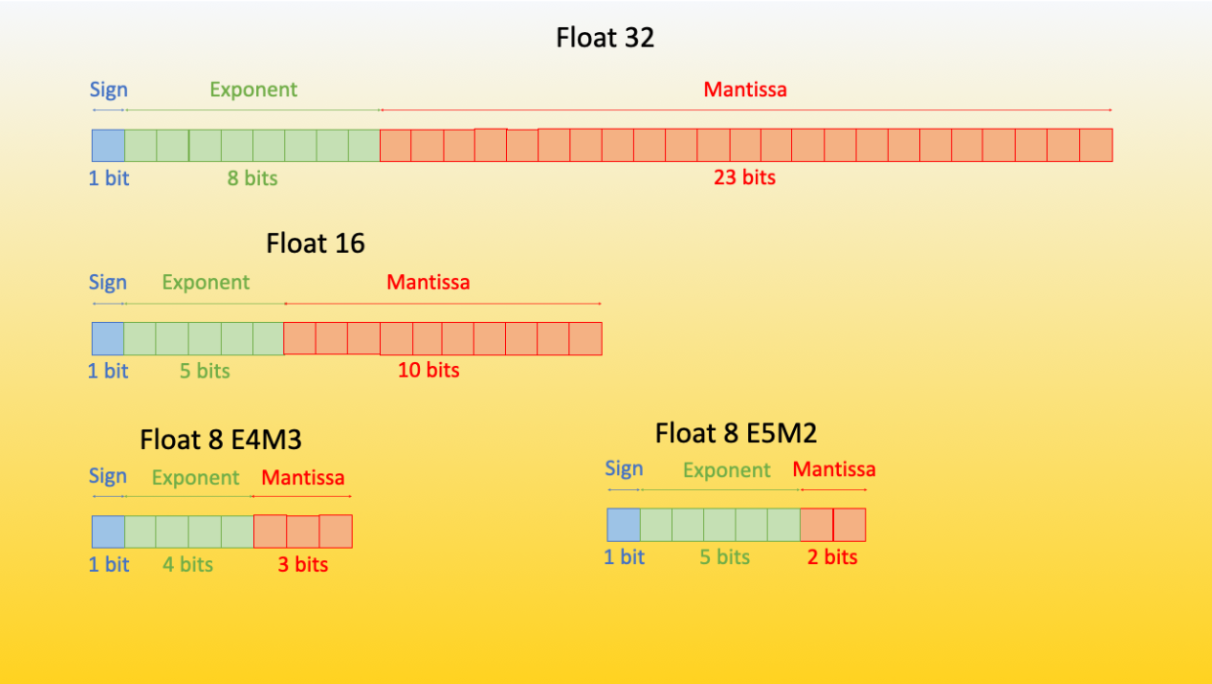

### Code Explanation

1. **Cache Directory & Local Files Option**
   - `cache_dir = "../models"`  
     Specifies the local directory where the model files and related data are cached to avoid repeated downloads.
  
   - `local_files_only = True`  
     When set to `True`, the code uses only the files already present locally. This is useful in scenarios with limited or no internet connectivity.

2. **Model Identifier**
   - `model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"`  
     Provides a unique identifier for the pre-trained model hosted on the Hugging Face Hub.

3. **Quantization Configuration**
   - `quantization_config = BitsAndBytesConfig(...)`  
     Configures the model to use 4-bit quantization. The parameters include:
     
     - `load_in_4bit=True`  
       Enables loading the model with 4-bit precision, reducing memory usage significantly.
     
     - `bnb_4bit_quant_type="nf4"`  
       Specifies the quantization type. `nf4` is a common setting for this quantization method.

        - **What It Is:**  
        The `nf4` option stands for a normalization-based 4-bit quantization method. It transforms full-precision weights into a normalized range and then quantizes them into 16 discrete levels.
  
        - **Benefits:**  
        This method is designed to better capture the distribution of the weights compared to other schemes. By normalizing the weights before quantization, `nf4` often achieves a superior balance between reduced memory usage and maintaining model accuracy.

        - **Other Settings**

            - **"fp4" (Floating Point 4-bit):**  
            This option uses a simplified floating-point style representation but with reduced bit-width. It typically applies a fixed format that might not adapt as well to the actual distribution of weights, potentially leading to a more significant drop in performance compared to `nf4`.

        - **Choosing the Right Option**

            - The `nf4` method is generally preferred when seeking to maintain high model accuracy while benefiting from the reduced memory footprint of 4-bit quantization.  
            - The `fp4` option, while simpler, may be used when a more traditional floating point representation is acceptable.

     
     - `bnb_4bit_use_double_quant=True`  
       Enables double quantization, which can further reduce the precision and model size while maintaining performance.
     
     - `bnb_4bit_compute_dtype=torch.bfloat16`  
       Sets the data type used during computation to `torch.bfloat16`, balancing efficiency and accuracy.

4. **Tokenizer Initialization**
   - `tokenizer = AutoTokenizer.from_pretrained(...)`  
     Initializes the tokenizer using the model identifier. It leverages the same `cache_dir` and `local_files_only` parameters to load the tokenizer from locally cached files.

5. **Model Initialization**
   - `model = AutoModelForCausalLM.from_pretrained(...)`  
     Loads the causal language model using the following parameters:
     
     - `model_id`: The model's unique identifier.
     - `quantization_config`: Applies the previously defined 4-bit quantization settings.
     - `device_map="auto"`: Automatically maps the model to available hardware devices (e.g., CPUs/GPUs).
     - `cache_dir` and `local_files_only`: Ensure that the model is loaded from the specified local directory only.
  
   - `model.train()`  
     Sets the model to training mode, which is necessary if further fine-tuning or training procedures will be performed.

In [3]:
cache_dir = "../models"  # Specify local cache directory
local_files_only = True  # Set to True if you want to use only local files

model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
# model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"

model, tokenizer = load_model_and_tokenizer(model_id, cache_dir=cache_dir, local_files_only=local_files_only)

Loading checkpoint shards: 100%|██████████| 8/8 [05:54<00:00, 44.27s/it]


# PEFT

### What is PEFT and What Does It Do?

**PEFT** stands for *Parameter-Efficient Fine-Tuning*. It is an approach (and sometimes a library) that allows you to fine-tune large language models by updating only a small subset of their parameters instead of all of them. This has several advantages:

- **Reduced Memory Usage:** Fine-tuning fewer parameters means that you require less memory during training.
- **Faster Training:** With fewer parameters updated, training time can be significantly reduced.
- **Lower Storage Requirements:** Only small "adapters" or additional parameters are stored rather than a full copy of the large model, making deployment easier.
- **Flexibility:** PEFT techniques include methods such as LoRA (Low-Rank Adaptation), adapters, prompt tuning, and prefix tuning.

## Is PEFT Related to QLoRA?

**QLoRA** is a technique that combines 4-bit quantization with LoRA fine-tuning. Here’s how they relate:

- **LoRA (Low-Rank Adaptation):** One of the methods under the umbrella of PEFT. LoRA fine-tunes a few low-rank matrices added to the model weights.
- **Quantization:** QLoRA applies 4-bit quantization to the model weights which greatly reduces the memory footprint.
- **Combining Both:** QLoRA leverages the benefits of both quantization (for efficient inference and reduced memory usage) and PEFT's LoRA approach (for efficient fine-tuning).

In [134]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [135]:
config = LoraConfig(
                    r=16,
                    target_modules=[
                        "q_proj",
                        "k_proj",
                        "v_proj",
                        "o_proj",
                        "gate_proj",
                        "up_proj",
                        "down_proj",
                    ],
                    lora_alpha=16,
                    lora_dropout=0, 
                    bias="none", 
                    task_type="CAUSAL_LM"
                )

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 40370176 || all params: 4393342464 || trainable%: 0.918894357332759


# Load Dataset

In [ ]:
signal_paths = "../data/unlabeled_10k/test/noiselessSignal/*.npy"
texts, labels = get_signals_as_text(signal_paths)
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1)
train_encodings = tokenizer(train_texts, return_tensors="pt", padding=True)
val_encodings = tokenizer(val_texts, return_tensors="pt", padding=True)
test_signal_paths = "../data/unlabeled_10k/test/noisySignal/*.npy"
test_texts, test_labels = get_signals_as_text(test_signal_paths)
test_encodings = tokenizer(test_texts, return_tensors="pt", padding=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/scipy/stats/_morestats.py:302: ComplexWarning: Casting complex values to real discards the imaginary part
  S[k] = np.sum(data**k, axis=0)
 70%|██████▉   | 1394/2000 [01:03<00:29, 20.53it/s]

In [ ]:
train_dataset = SignalTextDataset(train_encodings, train_labels)
val_dataset = SignalTextDataset(val_encodings, val_labels)
test_dataset = SignalTextDataset(test_encodings, test_labels)

# Finetune model

In [ ]:
# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

trainer = Trainer(
    model=model,
    train_dataset=data["train"],
    args=TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

trainer.args.logging_dir = "outputs"
trainer.args.report_to = ["tensorboard"]

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavi

Step,Training Loss
1,5.743600
2,3.925300
3,4.871400
4,4.794600
5,4.438300
6,4.542500
7,4.352500
8,3.671800
9,4.608100
10,3.637700


TrainOutput(global_step=10, training_loss=4.458573484420777, metrics={'train_runtime': 16.5886, 'train_samples_per_second': 2.411, 'train_steps_per_second': 0.603, 'total_flos': 58665661824000.0, 'train_loss': 4.458573484420777, 'epoch': 0.01594896331738437})

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


# Summarize a signal

In [ ]:
# Example usage:
file_path = '../data/unlabeled_10k/test/noisySignal/OQPSK_-0.24dB__006_20250127_145655.npy'
data = load_npy_file(file_path)
k=100

symbol_idx = get_symbol_index(data)
I, Q, magnitude, phase = extract_signal_features(data)
table = create_structured_table(symbol_idx, I, Q, magnitude, phase)
df_table = create_dataframe(table)

overall = compute_overall_summary(df_table)
print("Overall Summary:")
print(overall)

group = compute_group_summary(df_table, k=k)
print("\nGroup Summary (every k indices):")
print(group)

print(table_to_dict_list(overall))

Overall Summary:
       Parameter         Min         Max      Mean     Std Dev
0       I (Real)   -6.609375    6.960938  0.034119    2.226562
1  Q (Imaginary)   -6.351562    7.351562  0.034027    2.210938
2      Magnitude    0.106079    7.679688  2.837891    1.334961
3      Phase (°) -179.750000  179.750000  1.026367  102.500000

Group Summary (every k indices):
    Group      Parameter         Min         Max       Mean     Std Dev
0       0       I (Real)   -5.644531    4.964844   0.342615    2.476764
1       0      Magnitude    0.308350    5.890625   2.911269    1.370733
2       0      Phase (°) -165.000000  179.625000   4.929092  100.296614
3       0  Q (Imaginary)   -5.000000    4.542969  -0.230749    2.033207
4       1       I (Real)   -5.000000    5.949219  -0.362276    2.255762
5       1      Magnitude    0.344971    6.234375   2.713015    1.339803
6       1      Phase (°) -172.500000  175.125000   0.978916  110.900817
7       1  Q (Imaginary)   -4.402344    4.769531   0.00718

/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_sum = group_sum.stack(level=0).reset_index()
/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [ ]:
from glob import glob

noise_type = 'noiselessSignal'

module_paths = {
            '4ASK': glob(f'../data/unlabeled_10k/test/{noise_type}/4ASK*.npy'),
            '8ASK': glob(f'../data/unlabeled_10k/test/{noise_type}/8ASK*.npy'),
            '16PAM': glob(f'../data/unlabeled_10k/test/{noise_type}/16PAM*.npy'),
            'CPFSK': glob(f'../data/unlabeled_10k/test/{noise_type}/CPFSK*.npy'),
            'DQPSK': glob(f'../data/unlabeled_10k/test/{noise_type}/DQPSK*.npy'),
            'GFSK': glob(f'../data/unlabeled_10k/test/{noise_type}/GFSK*.npy'), 
            'GMSK': glob(f'../data/unlabeled_10k/test/{noise_type}/GMSK*.npy'),
            'OQPSK': glob(f'../data/unlabeled_10k/test/{noise_type}/OQPSK*.npy'),
            'OOK': glob(f'../data/unlabeled_10k/test/{noise_type}/OOK*.npy')
        }


# C_40 = {key:[] for key in module_paths.keys()}
# for key, paths in module_paths.items():
#     for path in paths:
#         data = load_npy_file(path)
#         N = data.shape[0]
#         c_21 = sum(abs(data) ** 2)/N
#         c_20 = sum(data ** 2)/N
#         c_40 = sum(data ** 4)/N - 3*c_20**2
#         C_40[key].append(c_40 / (c_21**2))


C_40 = {}
for key, paths in module_paths.items():
    for path in paths:
        data = load_npy_file(path)
        for N in [data.shape[0], data.shape[0]//2]:
            part_c40 = []
            for i in range(data.shape[0]//N):
                # N = data.shape[0]
                c_21 = sum(abs(data[i:(i+1)*N]) ** 2)/N
                c_20 = sum(data[i:(i+1)*N] ** 2)/N
                c_40 = sum(data[i:(i+1)*N] ** 4)/N - 3*c_20**2
                part_c40.append(c_40 / (c_21**2))
            if f'{key}_{N}' not in C_40.keys():
                C_40[f'{key}_{N}'] = []
            C_40[f'{key}_{N}'].append(np.mean(part_c40))

df = pd.DataFrame(C_40)

In [ ]:
df.mean()

4ASK_1024    -1.327348-0.025501j
4ASK_512     -1.736585-0.026810j
8ASK_1024    -1.214389-0.012977j
8ASK_512     -1.650433-0.014572j
16PAM_1024   -1.181599-0.009147j
16PAM_512    -1.626702-0.010315j
CPFSK_1024   -1.962412-0.008452j
CPFSK_512    -2.220464-0.007371j
DQPSK_1024    0.970752-0.010014j
DQPSK_512     0.736241-0.005022j
GFSK_1024    -1.953970+0.033329j
GFSK_512     -2.213887+0.029273j
GMSK_8192     0.004755+0.003377j
GMSK_4096    -0.015180-0.011124j
OQPSK_1024    0.971010+0.005629j
OQPSK_512     0.736436+0.002937j
OOK_1024     -0.987457-0.021106j
OOK_512      -1.477127-0.026659j
dtype: complex128

In [ ]:
df.std()

/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/numpy/_core/_methods.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/pandas/core/nanops.py:950: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(nanvar(values, axis=axis, skipna=skipna, ddof=ddof, mask=mask))


4ASK_1024          NaN
4ASK_512           NaN
8ASK_1024          NaN
8ASK_512           NaN
16PAM_1024         NaN
16PAM_512          NaN
CPFSK_1024         NaN
CPFSK_512          NaN
DQPSK_1024         NaN
DQPSK_512          NaN
GFSK_1024          NaN
GFSK_512           NaN
GMSK_8192     0.005593
GMSK_4096          NaN
OQPSK_1024         NaN
OQPSK_512          NaN
OOK_1024           NaN
OOK_512            NaN
dtype: float64

In [ ]:
# # Define a structured dtype with two int8 fields: 'real' and 'imag'
# complex32_dtype = np.dtype([('real', np.float16), ('imag', np.float16)])

# data = data.astype(complex32_dtype)
# print("Data new dtype:", data.dtype)
# data

In [ ]:
file_path = '../data/unlabeled_10k/test/noisySignal/OQPSK_-0.24dB__006_20250127_145655.npy'
stats_summary, _ = get_stats_context(file_path)
example_paths = get_example_paths(noise_type="noisySignal")

input_text = (
    f"Overall Signal Information: {stats_summary}\n"
)

prompt_prefix = f"""
You are an expert in wireless communication signal analysis.
Based solely on the detailed signal summaries provided below, determine the modulation type.
Focus exclusively on the quantitative information—both the overall signal statistics and the summary for every k-step.
Your answer must be strictly one of these modulation types (e.g., 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, QPSK, OQPSK, OOK) and nothing else.

Examples:
"""
prompt_examples = ""
for idx, ex_path in enumerate(example_paths.values()):
    ex_summary, ex_label = get_stats_context(ex_path)
    prompt_examples += f"""
Example {idx+1}:
Overall Signal Information: {ex_summary}
Modulation type: {ex_label}
"""
prompt_suffix = f"""

Overall Signal Information: {input_text}
Modulation type:
"""

prompt = prompt_prefix + prompt_examples + prompt_suffix

print(prompt)


You are an expert in wireless communication signal analysis.
Based solely on the detailed signal summaries provided below, determine the modulation type.
Focus exclusively on the quantitative information—both the overall signal statistics and the summary for every k-step.
Your answer must be strictly one of these modulation types (e.g., 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, QPSK, OQPSK, OOK) and nothing else.

Examples:

Example 1:
Overall Signal Information: {nobs: 1024, min: -7.28291-0.52755j, max: 7.47761-0.92365j, mean: -0.00901+0.01684j, variance: 5.28436-0.14411j, skewness: 0.01245-0.07525j, kurtosis: -0.57082+0.38327j, moment_1: 0.00000+0.00000j, moment_2: 5.27920-0.14397j, moment_3: 0.11360-0.91865j, moment_4: 68.23352+6.98124j, kstat_1: -0.00901, kstat_2: 5.28408, kstat_3: 0.12122, kstat_4: -15.25543, kstatvar_1: 0.00516, kstatvar_2: 0.03961}
Modulation type: 4ASK

Example 2:
Overall Signal Information: {nobs: 1024, min: -19.84887+0.85361j, max: 15.24534+4.75453j

/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/scipy/stats/_morestats.py:302: ComplexWarning: Casting complex values to real discards the imaginary part
  S[k] = np.sum(data**k, axis=0)


In [ ]:
torch.cuda.empty_cache()

# Specify an input prompt


# input_text = (
#     f"Signal data: {data.tolist()}\n"
#     f"Shape: {data.shape}, "
#     f"Min: {data.min()}, Max: {data.max()}, "
#     f"Mean: {data.mean():.3f}, Std: {data.std():.3f}"
# )

# prompt_prefix = f"""
# You are an expert in wireless communication signal analysis. Your task is to analyze and summarize the provided signal data. In your summary, include the following:
#   - Identification of the modulation type (e.g., 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, QPSK, OQPSK, OOK)
#   - An evaluation of noise levels and potential distortions (0 to 20dB)
#   - Insights into signal integrity and possible sources of interference
#   - A summary of the signal content
#   - Any information that can help in understanding the signal's content
# Your summary should be clear, concise, and technically detailed to assist engineers in quickly assessing the performance of the wireless communication system.

# Signal data: {input_text}
# """

four_ASK_path = '../data/unlabeled_10k/test/noisySignal/4ASK_-0.17dB__081_20250127_164342.npy'
eight_ASK_path = '../data/unlabeled_10k/test/noisySignal/8ASK_-0.11dB__016_20250127_164352.npy'
sixteen_PAM_path = '../data/unlabeled_10k/test/noisySignal/16PAM_-0.08dB__058_20250127_145951.npy'
CPFSK_path = '../data/unlabeled_10k/test/noisySignal/CPFSK_-0.03dB__088_20250127_164523.npy'
DQPSK_ASK_path = '../data/unlabeled_10k/test/noisySignal/DQPSK_-0.01dB__036_20250127_164655.npy'
GFSK_ASK_path = '../data/unlabeled_10k/test/noisySignal/GFSK_-0.05dB__042_20250127_164545.npy'
GMSK_ASK_path = '../data/unlabeled_10k/test/noisySignal/GMSK_-0.12dB__059_20250127_164925.npy'
OQPSK_path = '../data/unlabeled_10k/test/noisySignal/OQPSK_-0.24dB__006_20250127_145655.npy'
OOK_path = '../data/unlabeled_10k/test/noisySignal/OOK_-0.17dB__091_20250127_164311.npy'

example_path = [four_ASK_path, eight_ASK_path, sixteen_PAM_path, CPFSK_path, DQPSK_ASK_path, GFSK_ASK_path, GMSK_ASK_path, OQPSK_path, OOK_path]

div = 3
file_path = '../data/unlabeled_10k/test/noisySignal/OQPSK_-0.24dB__006_20250127_145655.npy'
input_overall, input_group, input_shape, input_k, input_label = get_signal_summary(file_path, div=div)

input_text = (
    f"Overall Signal Information: {table_to_dict_list(input_overall)}\n"
    f"Every {input_k}-step Signal Summary Information: {table_to_dict_list(input_group)}\n"
    f"Shape: {input_shape}, "
)

prompt_prefix = f"""
You are an expert in wireless communication signal analysis.
Based solely on the detailed signal summaries provided below, determine the modulation type.
Focus exclusively on the quantitative information—both the overall signal statistics and the summary for every k-step.
Your answer must be strictly one of these modulation types (e.g., 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, QPSK, OQPSK, OOK) and nothing else.

Examples:
"""
prompt_examples = ""
for idx, ex_path in enumerate(example_path):
    ex_overall, ex_group, ex_shape, ex_k, ex_label = get_signal_summary(ex_path, div=div)
    prompt_examples += f"""
Example {idx+1}:
Overall Signal Information: {table_to_dict_list(ex_overall)}
Every {ex_k}-step Signal Summary Information: {table_to_dict_list(ex_group)}
Shape: {ex_shape}
Modulation type: {ex_label}
"""
prompt_suffix = f"""

Overall Signal Information: {input_text}
Modulation type:
"""

prompt = prompt_prefix + prompt_examples + prompt_suffix

# print(prompt)
# print(len(prompt))

# Tokenize the input text and move tensors to the model's device
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
# print('Number of Tokens:', len(inputs[0]))

# # Generate a response with a maximum of 50 new tokens
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)

# # Decode and print the generated response, skipping special tokens
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(clean_response(response[len(prompt):]))

/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_sum = group_sum.stack(level=0).reset_index()
/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_sum = group_sum.stack(level=0).reset_index()
/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_s

OqpskTodeterminethe


# No Context

In [ ]:
from glob import glob
from tqdm import tqdm

torch.cuda.empty_cache()

module_signals = glob("../data/unlabeled_10k/test/noisySignal/*.npy")
k = 100
results = {'file_path': [], 'modulation_type': [], 'response': []}

batch_size = 1  # adjust batch size as needed
prompt_batch = []
file_batch = []

for file_path in tqdm(module_signals[:10]):
    data = load_npy_file(file_path)

    symbol_idx = get_symbol_index(data)
    I, Q, magnitude, phase = extract_signal_features(data)
    table = create_structured_table(symbol_idx, I, Q, magnitude, phase)
    df_table = create_dataframe(table)

    overall = compute_overall_summary(df_table)
    group = compute_group_summary(df_table, k=k)

    input_text = (
        f"Overall Signal Information: {table_to_dict_list(overall)}\n"
        f"Every {k}-step Signal Summary Information: {table_to_dict_list(group)}\n"
        f"Shape: {data.shape}, "
    )

    prompt_prefix = f"""
    You are an expert in wireless communication signal analysis. Your task is to identify the modulation type and summarize the digital signal data using the provided information. In your summary, include the following:
    - Identification of the modulation type by analyzing the overall and every k-step signal summary information.
    - Your answer should be only the name of the modulation type.
    Signal data: {input_text}
    No other text, no blabber. Modulation type:
    """
    prompt_batch.append(prompt_prefix)
    file_batch.append(file_path)

    if len(prompt_batch) == batch_size:
        inputs = tokenizer(prompt_batch, return_tensors="pt", padding=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
        decoded = []
        for prompt, out in zip(prompt_batch, outputs):
            full_text = tokenizer.decode(out, skip_special_tokens=True)
            # Remove the prompt part from the generated text
            generated = full_text[len(prompt):].strip()
            decoded.append(clean_response(generated))
        for fpath, text in zip(file_batch, decoded):
            results['file_path'].append(fpath)
            results['modulation_type'].append(fpath.split('/')[-1].split('_')[0])
            results['response'].append(text)
        prompt_batch = []
        file_batch = []

if prompt_batch:
    inputs = tokenizer(prompt_batch, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
    decoded = []
    for prompt, out in zip(prompt_batch, outputs):
        full_text = tokenizer.decode(out, skip_special_tokens=True)
        generated = full_text[len(prompt):].strip()
        decoded.append(clean_response(generated))
    for fpath, text in zip(file_batch, decoded):
        results['file_path'].append(fpath)
        results['modulation_type'].append(fpath.split('/')[-1].split('_')[0])
        results['response'].append(text)

results_df = pd.DataFrame(results)
results_df.to_csv('no_context_results.csv', index=False)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_sum = group_sum.stack(level=0).reset_index()
/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/woreom/miniconda3/envs/vlm/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inpu

,file_path,modulation_type,response
0,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,-Identifythemodulationtypebyanalyzingtheoveral...
1,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovidethemodulationtypebasedonthegivendata
2,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"Pleasereasonstepbystep,andputyourfinal"
3,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovideonlythemodulationtypebyanalyzingt...
4,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Youranswershouldbeonlythenameofthemodulation
5,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"Pleasereasonstepbystep,andputyourfinal"
6,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"ItseitherQAM,QPSK,"
7,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovidethemodulationtypebyanalyzingtheov...
8,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"So,basedontheoverallandeveryk-step"
9,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovideonlythemodulationtype.The


In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv('no_context_results.csv', index=False)
results_df

,file_path,modulation_type,response
0,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,-Identifythemodulationtypebyanalyzingtheoveral...
1,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovidethemodulationtypebasedonthegivendata
2,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"Pleasereasonstepbystep,andputyourfinal"
3,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovideonlythemodulationtypebyanalyzingt...
4,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Youranswershouldbeonlythenameofthemodulation
5,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"Pleasereasonstepbystep,andputyourfinal"
6,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"ItseitherQAM,QPSK,"
7,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovidethemodulationtypebyanalyzingtheov...
8,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,"So,basedontheoverallandeveryk-step"
9,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,Pleaseprovideonlythemodulationtype.The


# With Context

In [ ]:
from glob import glob
from tqdm import tqdm
# # Summarize a signal
torch.cuda.empty_cache()

four_ASK_path = '../data/unlabeled_10k/test/noisySignal/4ASK_-0.17dB__081_20250127_164342.npy'
eight_ASK_path = '../data/unlabeled_10k/test/noisySignal/8ASK_-0.11dB__016_20250127_164352.npy'
sixteen_PAM_path = '../data/unlabeled_10k/test/noisySignal/16PAM_-0.08dB__058_20250127_145951.npy'
CPFSK_path = '../data/unlabeled_10k/test/noisySignal/CPFSK_-0.03dB__088_20250127_164523.npy'
DQPSK_ASK_path = '../data/unlabeled_10k/test/noisySignal/DQPSK_-0.01dB__036_20250127_164655.npy'
GFSK_ASK_path = '../data/unlabeled_10k/test/noisySignal/GFSK_-0.05dB__042_20250127_164545.npy'
GMSK_ASK_path = '../data/unlabeled_10k/test/noisySignal/GMSK_-0.12dB__059_20250127_164925.npy'
OQPSK_path = '../data/unlabeled_10k/test/noisySignal/OQPSK_-0.24dB__006_20250127_145655.npy'
OOK_path = '../data/unlabeled_10k/test/noisySignal/OOK_-0.17dB__091_20250127_164311.npy'

example_path = [four_ASK_path, eight_ASK_path, sixteen_PAM_path, CPFSK_path, DQPSK_ASK_path, GFSK_ASK_path, GMSK_ASK_path, OQPSK_path, OOK_path]

module_signals = glob("../data/unlabeled_10k/test/noisySignal/*.npy")
# remove example path
module_signals = [x for x in module_signals if x not in example_path]

div = 3
results = {'file_path': [], 'modulation_type': [], 'response': []}

batch_size = 1  # adjust batch size as needed
prompt_batch = []
file_batch = []

for file_path in tqdm(module_signals[:10]):
    input_overall, input_group, input_shape, input_k, input_label = get_signal_summary(file_path, div=div)

    input_text = (
        f"Overall Signal Information: {table_to_dict_list(input_overall)}\n"
        f"Every {input_k}-step Signal Summary Information: {table_to_dict_list(input_group)}\n"
        f"Shape: {input_shape}, "
    )

    prompt_prefix = f"""
    You are an expert in wireless communication signal analysis.
    Based solely on the detailed signal summaries provided below, determine the modulation type.
    Focus exclusively on the quantitative information—both the overall signal statistics and the summary for every k-step.
    Your answer must be strictly one of these modulation types (e.g., 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, QPSK, OQPSK, OOK) and nothing else.

    Examples:
    """
    prompt_examples = ""
    for idx, ex_path in enumerate(example_path):
        ex_overall, ex_group, ex_shape, ex_k, ex_label = get_signal_summary(ex_path, div=div)
        prompt_examples += f"""
    Example {idx+1}:
    Overall Signal Information: {table_to_dict_list(ex_overall)}
    Every {ex_k}-step Signal Summary Information: {table_to_dict_list(ex_group)}
    Shape: {ex_shape}
    Modulation type: {ex_label}
    """
    prompt_suffix = f"""

    Overall Signal Information: {input_text}
    Modulation type:
    """

    prompt = prompt_prefix + prompt_examples + prompt_suffix

    prompt_batch.append(prompt)
    file_batch.append(file_path)

    if len(prompt_batch) == batch_size:
        inputs = tokenizer(prompt_batch, return_tensors="pt", padding=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
        decoded = []
        for prompt, out in zip(prompt_batch, outputs):
            full_text = tokenizer.decode(out, skip_special_tokens=True)
            # Remove the prompt part from the generated text
            generated = full_text[len(prompt):].strip()
            decoded.append(clean_response(generated))
        for fpath, text in zip(file_batch, decoded):
            results['file_path'].append(fpath)
            results['modulation_type'].append(fpath.split('/')[-1].split('_')[0])
            results['response'].append(text)
        prompt_batch = []
        file_batch = []
        torch.cuda.empty_cache()


if prompt_batch:
    inputs = tokenizer(prompt_batch, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
    decoded = []
    for prompt, out in zip(prompt_batch, outputs):
        full_text = tokenizer.decode(out, skip_special_tokens=True)
        generated = full_text[len(prompt):].strip()
        decoded.append(clean_response(generated))
    for fpath, text in zip(file_batch, decoded):
        results['file_path'].append(fpath)
        results['modulation_type'].append(fpath.split('/')[-1].split('_')[0])
        results['response'].append(text)
    torch.cuda.empty_cache()


results_df = pd.DataFrame(results)
results_df.to_csv('with_context_results.csv', index=False)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_sum = group_sum.stack(level=0).reset_index()
/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_sum = group_sum.stack(level=0).reset_index()
/tmp/ipykernel_5125/2642861994.py:119: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementati

,file_path,modulation_type,response
0,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,QPSK```Example
1,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKThemodulation
2,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,QFSKThemodulationtypeis
3,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,QPSKThemodulationtype
4,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKThemodulationtype
5,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKThemodulationtype
6,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKExample7:
7,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKExample1
8,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKThemodulationtype
9,../data/unlabeled_10k/test/noisySignal/16PAM_-...,16PAM,GFSKThemodulationtype


# New Context

In [ ]:
a = stats.describe(data)
a.skewness

np.complex128(0.0645269330513249+0.07992618729425238j)

In [ ]:
from scipy import stats

# Get the summary statistics
def get_stats_context(file_path):
    data = load_npy_file(file_path)
    label = file_path.split('/')[-1].split('_')[0]
    des_stats = stats.describe(data)
    stats_summary = {
        'nobs': str(des_stats.nobs),
        'min': str(des_stats.minmax[0]),
        'max': str(des_stats.minmax[1]),
        'mean': str(des_stats.mean),
        'variance': str(des_stats.variance),
        'skewness': str(des_stats.skewness),
        'kurtosis': str(des_stats.kurtosis),
    }
    for i in range(1, 5):
        stats_summary[f'moment_{i}'] = str(stats.moment(data, order=i))

    for i in range(1, 5):
        stats_summary[f'kstat_{i}'] = str(stats.kstat(data, i))

    for i in range(1, 3):
        stats_summary[f'kstatvar_{i}'] = str(stats.kstatvar(data, i))


    return str(stats_summary).replace("'", ''), label

# Prompt Test

In [6]:
print(prompt)

### Instructions:
You are an expert quantitative analyst in wireless communication modulation.
Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type.
1. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT.
2. No OTHER TEXT, NO BLABBER.
### Example 1: Overall Signal Information: {nobs: 1024, min: -7.3-0.5j, max: 7.5-0.9j, mean: -0.0+0.0j, variance: 5.3-0.1j, skewness: 0.0-0.1j, kurtosis: -0.6+0.4j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 5.3-0.1j, moment_3: 0.1-0.9j, moment_4: 68.2+7.0j, moment_5: 10.6-39.6j, moment_6: 1476.9+176.9j, moment_7: 2342.5-1918.5j, moment_8: 32478.5-1661.1j, moment_9: -36975.3-184979.0j, kstat_1: -0.0, kstat_2: 5.3, kstat_3: 0.1, kstat_4: -15.3, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 1: 4ASK
### Example 2: Overall Signal Information: {nobs: 1024, min: -6.6+1.9j, max: 7.5+1.6j, mean: -0.1-0.0j, variance: 5.3-0.2j, skewness: 0.2-0.1j, kurtosis: -1.3-0.3j, mo

In [9]:
# stop_strings (str or List[str], optional)
import random

class_names = ['4ASK', '4PAM', '8ASK', '16PAM', 'CPFSK', 'DQPSK', 'GFSK', 'GMSK', 'OQPSK', 'OOK']
noise_type = 'noisySignal'
file_path = f'../data/unlabeled_10k/test/noisySignal/16PAM_-0.58dB__095_20250127_164745.npy'
# file_path = random.choice(glob('../data/unlabeled_10k/test/noisySignal/*.npy'))
example_paths = {
        '4ASK': f'../data/unlabeled_10k/test/{noise_type}/4ASK_-0.17dB__081_20250127_164342.npy',
        '4PAM': f'../data/unlabeled_10k/test/{noise_type}/4PAM_-0.00dB__031_20250127_164618.npy',
        '8ASK': f'../data/unlabeled_10k/test/{noise_type}/8ASK_-0.11dB__016_20250127_164352.npy',
        '16PAM': f'../data/unlabeled_10k/test/{noise_type}/16PAM_-0.08dB__058_20250127_145951.npy',
        'CPFSK': f'../data/unlabeled_10k/test/{noise_type}/CPFSK_-0.03dB__088_20250127_164523.npy',
        'DQPSK': f'../data/unlabeled_10k/test/{noise_type}/DQPSK_-0.01dB__036_20250127_164655.npy',
        'GFSK': f'../data/unlabeled_10k/test/{noise_type}/GFSK_-0.05dB__042_20250127_164545.npy', 
        'GMSK': f'../data/unlabeled_10k/test/{noise_type}/GMSK_-0.12dB__059_20250127_164925.npy',
        'OQPSK': f'../data/unlabeled_10k/test/{noise_type}/OQPSK_-0.24dB__006_20250127_145655.npy',
        'OOK': f'../data/unlabeled_10k/test/{noise_type}/OOK_-0.17dB__091_20250127_164311.npy'
    }

stats_summary, label = get_stats_context(file_path, decimal_precision=3)
input_text = (
    f"Overall Signal Information: {stats_summary}"
)

PROMPT_TEMPELATE = """### Instructions:
You are an expert quantitative analyst in wireless communication modulation.
Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type.
1. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT.
2. No OTHER TEXT, NO BLABBER.{}
### Question:\n{}
YOUR OPTIONS ARE: {}
### Answer: {}"""

# prompt_prefix = f"""### Instructions
# You are an expert quantitative analyst in wireless communication modulation.
# Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type."""

prompt_examples = ""
for idx, ex_path in enumerate(example_paths.values()):
    ex_summary, ex_label = get_stats_context(ex_path, decimal_precision=1)
    prompt_examples += f"""
### Example {idx+1}: Overall Signal Information: {ex_summary} ### Answer {idx+1}: {ex_label}"""

# prompt_suffix = f"""
# YOUR ANSWER MUST BE STRICTLY ONE AND ONLY ONE OF {", ".join(class_names)} MODULATION TYPES AND NOTHING ELSE. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT. No OTHER TEXT, NO BLABBER. What is the modulation type of this signal information: {input_text}
# ### Response: ### Answer:"""

# prompt = prompt_prefix + prompt_examples + prompt_suffix

prompt = PROMPT_TEMPELATE.format(prompt_examples, input_text, ", ".join(class_names), '')
# print(prompt)


# cache_dir = "../models"  # Specify local cache directory
# local_files_only = True  # Set to True if you want to use only local files

# # Tokenize the input text and move tensors to the model's device
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
print('Number of Tokens:', len(inputs[0]))
# # print(prompt)

outputs = model.generate(**inputs, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id, temperature=0.2)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(full_text)
print(f'\n ### TRUE ANSWER: {label}')
torch.cuda.empty_cache()

Number of Tokens: 3890
### Instructions:
You are an expert quantitative analyst in wireless communication modulation.
Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type.
1. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT.
2. No OTHER TEXT, NO BLABBER.
### Example 1: Overall Signal Information: {nobs: 1024, min: -7.3-0.5j, max: 7.5-0.9j, mean: -0.0+0.0j, variance: 5.3-0.1j, skewness: 0.0-0.1j, kurtosis: -0.6+0.4j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 5.3-0.1j, moment_3: 0.1-0.9j, moment_4: 68.2+7.0j, moment_5: 10.6-39.6j, moment_6: 1476.9+176.9j, moment_7: 2342.5-1918.5j, moment_8: 32478.5-1661.1j, moment_9: -36975.3-184979.0j, kstat_1: -0.0, kstat_2: 5.3, kstat_3: 0.1, kstat_4: -15.3, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 1: 4ASK
### Example 2: Overall Signal Information: {nobs: 1024, min: -6.6+1.9j, max: 7.5+1.6j, mean: -0.1-0.0j, variance: 5.3-0.2j, skewness: 0.2-0.1j, 

In [68]:
outputs = model.generate(**{'input_ids':train_encodings['input_ids'][0].unsqueeze(0), 'attention_mask':train_encodings['attention_mask'][0].unsqueeze(0)}, max_new_tokens=10, pad_token_id=tokenizer.eos_token_id)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(full_text)

NameError: name 'train_encodings' is not defined

In [ ]:
### Instructions:
You are an expert quantitative analyst in wireless communication modulation.
Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type.
1. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT.
2. No OTHER TEXT, NO BLABBER.
### Example 1: Overall Signal Information: {nobs: 1024, min: -7.3-0.5j, max: 7.5-0.9j, mean: -0.0+0.0j, variance: 5.3-0.1j, skewness: 0.0-0.1j, kurtosis: -0.6+0.4j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 5.3-0.1j, moment_3: 0.1-0.9j, moment_4: 68.2+7.0j, moment_5: 10.6-39.6j, moment_6: 1476.9+176.9j, moment_7: 2342.5-1918.5j, moment_8: 32478.5-1661.1j, moment_9: -36975.3-184979.0j, kstat_1: -0.0, kstat_2: 5.3, kstat_3: 0.1, kstat_4: -15.3, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 1: 4ASK
### Example 2: Overall Signal Information: {nobs: 1024, min: -6.6+1.9j, max: 7.5+1.6j, mean: -0.1-0.0j, variance: 5.3-0.2j, skewness: 0.2-0.1j, kurtosis: -1.3-0.3j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 5.3-0.2j, moment_3: 2.2-0.8j, moment_4: 46.7-11.3j, moment_5: -33.6-6.3j, moment_6: -117.9-295.7j, moment_7: -2291.5+1887.6j, moment_8: -37158.4-8095.4j, moment_9: -195669.1+151075.8j, kstat_1: -0.1, kstat_2: 5.3, kstat_3: 2.2, kstat_4: -36.9, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 2: 4PAM
### Example 3: Overall Signal Information: {nobs: 1024, min: -19.8+0.9j, max: 15.2+4.8j, mean: 0.2-0.0j, variance: 22.8+1.7j, skewness: -0.3+0.1j, kurtosis: -1.2+0.3j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 22.7+1.7j, moment_3: -28.1+5.4j, moment_4: 899.1+308.9j, moment_5: -5224.2+1192.3j, moment_6: 104140.1+39359.9j, moment_7: -1628447.4+615858.4j, moment_8: 30017454.2-411331.4j, moment_9: -583586599.3+183431905.1j, kstat_1: 0.2, kstat_2: 22.8, kstat_3: -28.2, kstat_4: -653.6, kstatvar_1: 0.0, kstatvar_2: 0.4} ### Answer 3: 8ASK
### Example 4: Overall Signal Information: {nobs: 1024, min: -30.7+1.6j, max: 36.7-15.3j, mean: -0.0+0.1j, variance: 88.9-16.8j, skewness: 0.0+0.0j, kurtosis: -1.4-0.4j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 88.8-16.7j, moment_3: 29.4-6.7j, moment_4: 11121.3-7935.0j, moment_5: -87690.6-143612.7j, moment_6: -1116121.5-5801597.9j, moment_7: -239822379.5-18513335.4j, moment_8: -6730965147.3-2133209993.3j, moment_9: -303396811496.2+163375946256.0j, kstat_1: -0.0, kstat_2: 88.9, kstat_3: 33.7, kstat_4: -12580.2, kstatvar_1: 0.1, kstatvar_2: 3.2} ### Answer 4: 16PAM
### Example 5: Overall Signal Information: {nobs: 1024, min: -2.4-1.5j, max: 2.1-1.7j, mean: 0.0-0.0j, variance: -1.0-0.0j, skewness: nan+0.0j, kurtosis: nan+0.0j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: -1.0-0.0j, moment_3: -0.2-0.1j, moment_4: 1.0-0.4j, moment_5: 1.9+0.8j, moment_6: -4.7+6.8j, moment_7: -12.1-10.6j, moment_8: 19.4-56.4j, moment_9: 65.0+119.9j, kstat_1: 0.0, kstat_2: -1.0, kstat_3: -0.2, kstat_4: -2.1, kstatvar_1: -0.0, kstatvar_2: 0.0} ### Answer 5: CPFSK
### Example 6: Overall Signal Information: {nobs: 1024, min: -2.8-0.2j, max: 2.7+0.2j, mean: -0.0-0.0j, variance: 0.1+0.0j, skewness: -0.5-0.8j, kurtosis: 70.6-57.5j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 0.1+0.0j, moment_3: 0.0-0.0j, moment_4: 0.8+0.2j, moment_5: 0.3+0.8j, moment_6: -0.1+0.4j, moment_7: 8.2-0.7j, moment_8: 4.8+0.5j, moment_9: 11.3+22.4j, kstat_1: -0.0, kstat_2: 0.1, kstat_3: 0.0, kstat_4: 0.7, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 6: DQPSK
### Example 7: Overall Signal Information: {nobs: 1024, min: -2.2-0.3j, max: 2.8-0.2j, mean: 0.0+0.0j, variance: -0.9+0.1j, skewness: nan+0.0j, kurtosis: nan+0.0j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: -0.9+0.1j, moment_3: 0.0-0.2j, moment_4: 0.9-0.1j, moment_5: 0.2+1.0j, moment_6: 0.8-4.3j, moment_7: -0.1-4.3j, moment_8: -0.9+48.2j, moment_9: -20.5+40.8j, kstat_1: 0.0, kstat_2: -0.9, kstat_3: 0.0, kstat_4: -1.8, kstatvar_1: -0.0, kstatvar_2: 0.0} ### Answer 7: GFSK
### Example 8: Overall Signal Information: {nobs: 8192, min: -3.0-0.3j, max: 3.8+0.3j, mean: 0.4+0.0j, variance: 0.1+0.0j, skewness: -0.1-0.3j, kurtosis: 8.9+10.5j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 0.1+0.0j, moment_3: -0.0-0.0j, moment_4: 0.2+0.2j, moment_5: -0.3-0.4j, moment_6: 0.4+0.3j, moment_7: 2.8+0.3j, moment_8: -4.2-1.2j, moment_9: -14.4-10.7j, kstat_1: 0.4, kstat_2: 0.1, kstat_3: -0.0, kstat_4: 0.1, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 8: GMSK
### Example 9: Overall Signal Information: {nobs: 1024, min: -6.6+1.7j, max: 7.0-3.2j, mean: 0.0+0.0j, variance: 0.1-0.5j, skewness: 0.2+2.5j, kurtosis: -90.0+54.7j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 0.1-0.5j, moment_3: 0.7-0.5j, moment_4: 22.5-6.4j, moment_5: -60.2-3.9j, moment_6: -165.9+201.6j, moment_7: -1027.9+1617.5j, moment_8: -8363.2-11454.4j, moment_9: -139027.7+168312.7j, kstat_1: 0.0, kstat_2: 0.1, kstat_3: 0.7, kstat_4: 22.7, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 9: OQPSK
### Example 10: Overall Signal Information: {nobs: 1024, min: -1.4-1.0j, max: 2.4+0.7j, mean: 0.5+0.0j, variance: 0.2+0.0j, skewness: -0.1+0.2j, kurtosis: -0.5+1.4j, moment_0: 1.0+0.0j, moment_1: 0.0+0.0j, moment_2: 0.2+0.0j, moment_3: -0.0+0.0j, moment_4: 0.1+0.1j, moment_5: -0.0-0.0j, moment_6: -0.1+0.1j, moment_7: -0.1+0.0j, moment_8: -0.3+0.3j, moment_9: 0.2+0.8j, kstat_1: 0.5, kstat_2: 0.2, kstat_3: -0.0, kstat_4: -0.0, kstatvar_1: 0.0, kstatvar_2: 0.0} ### Answer 10: OOK
### Question:
Overall Signal Information: {nobs: 1024, min: -33.502+5.905j, max: 32.946-0.873j, mean: -0.629-0.000j, variance: 91.335+14.316j, skewness: -0.028-0.107j, kurtosis: -1.328-1.127j, moment_0: 1.000+0.000j, moment_1: 0.000+0.000j, moment_2: 91.246+14.302j, moment_3: -2.093-97.715j, moment_4: 16521.730-4790.544j, moment_5: -7101.664-52723.927j, moment_6: 6196779.564-7201749.478j, moment_7: 64057547.113-24438498.941j, moment_8: 2842222347.729-1168103339.457j, moment_9: 94465304658.504+33115399833.821j, kstat_1: -0.629, kstat_2: 91.335, kstat_3: -2.092, kstat_4: -8464.883, kstatvar_1: 0.089, kstatvar_2: 8.027}
the answer is one of: 4ASK, 4PAM, 8ASK, 16PAM, CPFSK, DQPSK, GFSK, GMSK, OQPSK, OOK


In [ ]:
train_encodings['input_ids'][0].unsqueeze(0).shape

torch.Size([1, 3413])

In [ ]:
prompt[prompt.find('### Response: ### Answer:')+ len('### Response: ### Answer:'):]

'### Response: ### Answer:'

In [ ]:
a = """4PAM

Wait, I need to"""

'4PAM' in a

True

# UNSLOTH

# Load SFTrainer

In [ ]:
cache_dir='../models'
local_files_only=True
model_id = '../src/prompt/model_traning_outputs/checkpoint-2147'

quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16
        )

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    cache_dir=cache_dir,
    local_files_only=local_files_only
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto",
    cache_dir=cache_dir,
    local_files_only=local_files_only
)
model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [01:15<00:00, 37.89s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3584, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=3584, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3584, out_features=512, bias=True)
            (lora_dropout): ModuleDict(
              (default): Iden

In [ ]:
# stop_strings (str or List[str], optional)
import random

class_names = ['4ASK', '4PAM', '8ASK', '16PAM', 'CPFSK', 'DQPSK', 'GFSK', 'GMSK', 'OQPSK', 'OOK']

file_path = '../data/unlabeled_10k/test/noiselessSignal/OQPSK_9.52dB__083_20250127_164445.npy'
file_path = random.choice(glob('../data/unlabeled_10k/test/noisySignal/*.npy'))
noise_type = 'noiselessSignal'
example_paths = {
        '4ASK': f'../data/unlabeled_10k/test/{noise_type}/4ASK_-0.17dB__081_20250127_164342.npy',
        '4PAM': f'../data/unlabeled_10k/test/{noise_type}/4PAM_-0.00dB__031_20250127_164618.npy',
        '8ASK': f'../data/unlabeled_10k/test/{noise_type}/8ASK_-0.11dB__016_20250127_164352.npy',
        '16PAM': f'../data/unlabeled_10k/test/{noise_type}/16PAM_-0.08dB__058_20250127_145951.npy',
        'CPFSK': f'../data/unlabeled_10k/test/{noise_type}/CPFSK_-0.03dB__088_20250127_164523.npy',
        'DQPSK': f'../data/unlabeled_10k/test/{noise_type}/DQPSK_-0.01dB__036_20250127_164655.npy',
        'GFSK': f'../data/unlabeled_10k/test/{noise_type}/GFSK_-0.05dB__042_20250127_164545.npy', 
        'GMSK': f'../data/unlabeled_10k/test/{noise_type}/GMSK_-0.12dB__059_20250127_164925.npy',
        'OQPSK': f'../data/unlabeled_10k/test/{noise_type}/OQPSK_-0.24dB__006_20250127_145655.npy',
        'OOK': f'../data/unlabeled_10k/test/{noise_type}/OOK_-0.17dB__091_20250127_164311.npy'
    }

stats_summary, label = get_stats_context(file_path)
input_text = (
    f"Overall Signal Information: {stats_summary}"
)

prompt_prefix = f"""### Instructions
You are an expert quantitative analyst in wireless communication modulation.
Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type."""

prompt_examples = ""
for idx, ex_path in enumerate(example_paths.values()):
    ex_summary, ex_label = get_stats_context(ex_path)
    prompt_examples += f"""
### Example {idx+1}: Overall Signal Information: {ex_summary} ### Answer {idx+1}: {ex_label}"""

prompt_suffix = f"""
YOUR ANSWER MUST BE STRICTLY ONE AND ONLY ONE OF {", ".join(class_names)} MODULATION TYPES AND NOTHING ELSE. DO NOT PROVIDE ANY ADDITIONAL INFORMATION OR CONTEXT. No OTHER TEXT, NO BLABBER.
### Question: {input_text}
### Answer:"""

prompt = prompt_prefix + prompt_examples + prompt_suffix

# Tokenize the input text and move tensors to the model's device
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
print('Number of Tokens:', len(inputs[0]))
# print(prompt)

outputs = model.generate(**inputs, max_new_tokens=4, pad_token_id=tokenizer.eos_token_id, temperature=0.1)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(full_text)
print(f'### TRUE ANSWER: {label}')
torch.cuda.empty_cache()

Number of Tokens: 3711
### Instructions
You are an expert quantitative analyst in wireless communication modulation.
Based on your knowledge in wireless communication modulation and the detailed signal statistics provided below, determine the modulation type.
### Example 1: Overall Signal Information: {nobs: 1024, min: -3.00000+0.00040j, max: 3.00000+0.00003j, mean: 0.06251-0.00042j, variance: 4.96352-0.21473j, skewness: -0.02764+0.00003j, kurtosis: -1.35201-0.00003j, moment_1: 0.00000+0.00000j, moment_2: 4.95867-0.21452j, moment_3: -0.30502+0.02010j, moment_4: 40.44568-3.50670j, kstat_1: 0.06251, kstat_2: 4.96352, kstat_3: -0.30619, kstat_4: -33.40337, kstatvar_1: 0.00485, kstatvar_2: 0.01551} ### Answer 1: 4ASK
### Example 2: Overall Signal Information: {nobs: 1024, min: -3.00000+0.00009j, max: 3.00000-0.00036j, mean: -0.09178+0.00205j, variance: 5.07022-0.30546j, skewness: 0.04664-0.00076j, kurtosis: -1.38064+0.00040j, moment_1: 0.00000+0.00000j, moment_2: 5.06527-0.30516j, moment_3